# Imports

In [3]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import snowflake.connector

# Date
import datetime as dt
import time
from datetime import timedelta

In [4]:
# # Gets the cursor
# con = snowflake.connector.connect(
#     user='meagan',
#     password='',
#     account='hu40871.us-east-1',
#     warehouse='ANALYSIS'
#     )
# cur = con.cursor()

# # insert query here
# cur.execute('''
#     SELECT  * 
#     FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
#            ''')

## Acuity

In [5]:
silver = pd.read_csv('Acuity.csv')

In [6]:
# Create a copy of the DB
silver_acuity = silver.copy()
silver_acuity.shape

(21449, 20)

In [7]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

# Check for null values
# sns.heatmap(silver_acuity.isnull(), cbar=False)
silver_acuity.isnull().sum()

EVENT                          0
APPOINTMENT_BODY_CALENDAR    278
EMAIL                        360
APPOINTMENT_BODY_DATE        278
APPOINTMENT_BODY_DURATION    278
APPOINTMENT_DATE_TIME        278
APPOINTMENT_BODY_TYPE        278
APPOINTMENT_BODY_CANCELED    278
dtype: int64

In [8]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    4385
Name: EVENT, dtype: int64

In [9]:
# drop irrelevant appointments
na_dict= {'True' : np.nan}

silver_acuity['APPOINTMENT_BODY_CANCELED'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
# silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

In [10]:
silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

False    4384
True        1
Name: APPOINTMENT_BODY_CANCELED, dtype: int64

In [11]:
# drop irrelevant appointments
na_dict= {'Hair Mineral Analysis Appointment':np.nan,
          'Follow Up Consultation':np.nan,
          'Customer consultation':np.nan,
          'Case Study':np.nan}

silver_acuity['APPOINTMENT_BODY_TYPE'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      3697
Hair Mineral Analysis - Acquisition       3
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [12]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     3312
False     388
Name: Complete, dtype: int64

In [13]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')

# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    3312
Name: Complete, dtype: int64

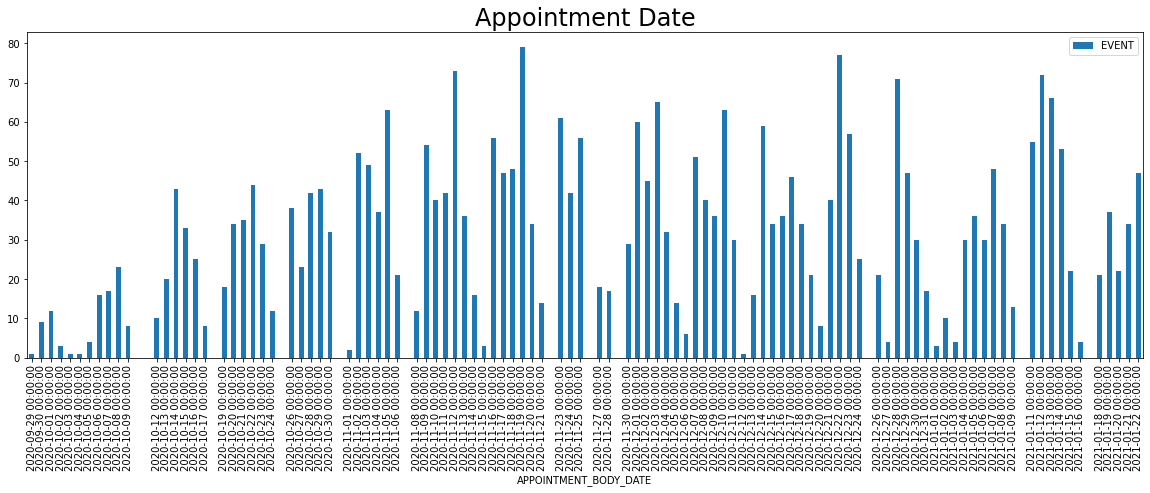

In [14]:
# Group by event, for a visual only 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

chart.plot(kind='bar',figsize=(20,6))
plt.title("Appointment Date", size= 24)
plt.show()

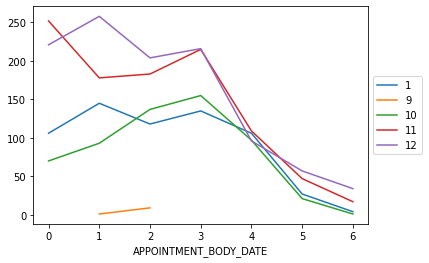

In [15]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.month])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [16]:
# min(silver_acuity['APPOINTMENT_BODY_DATE'])
# max(silver_acuity['APPOINTMENT_BODY_DATE'])

In [17]:
# Looking at specific email addresses
# silver_acuity.loc[silver_acuity['EMAIL']=='XXXX@yahoo.com']

# AGG
clean_acuity = silver_acuity.loc[silver_acuity.groupby('EMAIL')['APPOINTMENT_BODY_DATE'].idxmin()]
clean_acuity.shape

(2941, 10)

In [18]:
clean_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      2940
Hair Mineral Analysis - Acquisition       1
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [19]:
clean_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

False    2941
Name: APPOINTMENT_BODY_CANCELED, dtype: int64

In [20]:
#QA instances
smail = clean_acuity['EMAIL'].nunique()
print ('unique emails = ',smail)

unique emails =  2941


## SUB

In [21]:
gold_sub = pd.read_csv('GOLD.csv')

In [22]:
# Create a copy of the dataframe
gold = gold_sub.copy()
gold.columns

Index([''SUBSCRIPTION_ID'', ''CUSTOMER_ID'', ''EMAIL'', ''STATUS'',
       ''ITEM_NAME'', ''ITEM_GROUP'', ''ITEM_SUB_TYPE'', ''ITEM_GENDER'',
       ''TOTAL_ITEMS'', ''FIRST_ORDER_AT'', ''GROSS_ORDER_VALUE'',
       ''TOTAL_ORDERS'', ''TOTAL_ORDER_VALUE''],
      dtype='object')

In [23]:
# Change dates to datetime 
gold['FIRST_ORDER_AT'] = pd.to_datetime(gold['FIRST_ORDER_AT'])
gold.info()

KeyError: 'FIRST_ORDER_AT'

In [ ]:
# min(gold['FIRST_ORDER_AT'])
# max(gold['FIRST_ORDER_AT'])

yyy = gold.shape
gemail = gold['EMAIL'].nunique()
print ('shape = ',yyy)
print ('unique emails = ',gemail)

In [ ]:
# clean up item gender
gold.loc[gold['ITEM_GENDER'] =='Men,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Men,Women,Men,Women,Women,Women,Men,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Men,Women,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women,Women', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,Men', 'ITEM_GENDER']= 'Combination'
gold.loc[gold['ITEM_GENDER'] =='Women,All', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Women', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Women,Women', 'ITEM_GENDER']= 'Women'
gold.loc[gold['ITEM_GENDER'] =='Men,Men', 'ITEM_GENDER']= 'Men'

gold['ITEM_GENDER'].value_counts()

In [ ]:
# AGG
df = gold.loc[gold.groupby('EMAIL')['GROSS_ORDER_VALUE'].idxmin()]

In [ ]:
gross = df['GROSS_ORDER_VALUE'].mean()
orderValue = df['TOTAL_ORDER_VALUE'].mean()
Items  = df['TOTAL_ITEMS'].mean()
orders = df['TOTAL_ORDERS'].mean()

print('GROSS_ORDER_VALUE = ',gross)
print('TOTAL_ORDER_VALUE = ',orderValue)
print('TOTAL_ITEMS = ',Items)
print('TOTAL_ORDERS = ',orders)

## Merge

In [ ]:
sub1 = pd.merge(clean_acuity,df,how='left',on='EMAIL')

In [ ]:
# Create a copy of the dataframe
sub = sub1.copy()

sub = sub[[ 'EMAIL','APPOINTMENT_BODY_DATE', 'FIRST_ORDER_AT',\
           'ITEM_GROUP', 'ITEM_SUB_TYPE','TOTAL_ITEMS','TOTAL_ORDERS',
           'ITEM_NAME', 'ITEM_GENDER', 'GROSS_ORDER_VALUE','TOTAL_ORDER_VALUE']]
sub.info()

In [ ]:
sub['FIRST_ORDER_AT']=pd.to_datetime(sub['FIRST_ORDER_AT'])

sub['TimeDifference'] = \
(((sub['APPOINTMENT_BODY_DATE']))-(sub['FIRST_ORDER_AT']))

submail = sub['EMAIL'].nunique()
print ('unique emails = ',submail)

In [ ]:
# Shouldn't need this
# df['GROSS_ORDER_VALUE']=df['GROSS_ORDER_VALUE'].astype(float, errors='ignore')
# sub['GROSS_ORDER_VALUE'] = sub['GROSS_ORDER_VALUE'].astype(float, errors='ignore')
# df['TOTAL_ORDER_VALUE'] = df['TOTAL_ORDER_VALUE'].astype(float, errors='ignore')
# sub['TOTAL_ORDER_VALUE'] = sub['TOTAL_ORDER_VALUE'].astype(float, errors='ignore')
# df['TOTAL_ITEMS']  = df['TOTAL_ITEMS'].astype(float, errors='ignore')
# df['TOTAL_ORDERS'] = df['TOTAL_ORDERS'].astype(float, errors='ignore')

In [ ]:
gross = df['GROSS_ORDER_VALUE'].mean()
cgross = sub['GROSS_ORDER_VALUE'].mean()
OV = df['TOTAL_ORDER_VALUE'].mean()
COV = sub['TOTAL_ORDER_VALUE'].mean()
Items  = df['TOTAL_ITEMS'].mean()
orders = df['TOTAL_ORDERS'].mean()

print('Total Gross Order Value = ',gross)
print('Consult Gross Order Value = ',cgross)

print('Total Gross Order Value = ',OV)
print('Consult Gross Order Value = ',COV)

In [24]:
# clean up item sub
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Prepay 6', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan ', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 3']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,Non-Sub']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 2']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan']= 'Combination'

sub['ITEM_SUB_TYPE'].value_counts()

NameError: name 'sub' is not defined

In [ ]:
# Export data
sub.to_csv('sub.csv')

In [25]:
sub.shape

NameError: name 'sub' is not defined